### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [2]:
df_orig = pd.read_csv('housing.csv')
df_orig.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


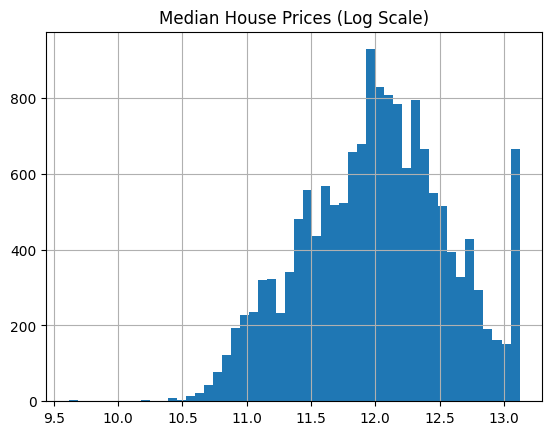

In [3]:
df = (
    df_orig[df_orig['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
    .fillna(0)
    .assign(median_house_value=np.log1p(df_orig['median_house_value']))
)
df.median_house_value.hist(bins=50);
plt.title('Median House Prices (Log Scale)');

In [4]:
random_seed = 1

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_seed)
print(f'train: {len(df_train)/len(df):.2%}')
print(f'val: {len(df_val)/len(df):.2%}')
print(f'test: {len(df_test)/len(df):.2%}')

train: 59.99%
val: 20.00%
test: 20.00%


In [6]:
target = 'median_house_value'
y_train = df_train.pop(target)
y_val = df_val.pop(target)
y_test = df_test.pop(target)

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [7]:
model = DecisionTreeRegressor(max_depth=1, random_state=random_seed)

In [8]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [9]:
print(export_text(model, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



> **Answer 1**: `ocean_proximity`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [10]:
model = RandomForestRegressor(n_estimators=10, random_state=random_seed, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
np.sqrt(mean_squared_error(model.predict(X_val), y_val)).round(4)

0.245

> **Answer 2**: `0.245`

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [12]:
rmses = []

for n_estimator in np.arange(10, 201, 10):
    print(f'{n_estimator=:4d}')
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=random_seed, n_jobs=-1)
    model.fit(X_train, y_train)
    rmses.append(
        (
            n_estimator, 
            np.sqrt(mean_squared_error(model.predict(X_val), y_val)).round(3)
        )
    )

n_estimator=  10
n_estimator=  20
n_estimator=  30
n_estimator=  40
n_estimator=  50
n_estimator=  60
n_estimator=  70
n_estimator=  80
n_estimator=  90
n_estimator= 100
n_estimator= 110
n_estimator= 120
n_estimator= 130
n_estimator= 140
n_estimator= 150
n_estimator= 160
n_estimator= 170
n_estimator= 180
n_estimator= 190
n_estimator= 200


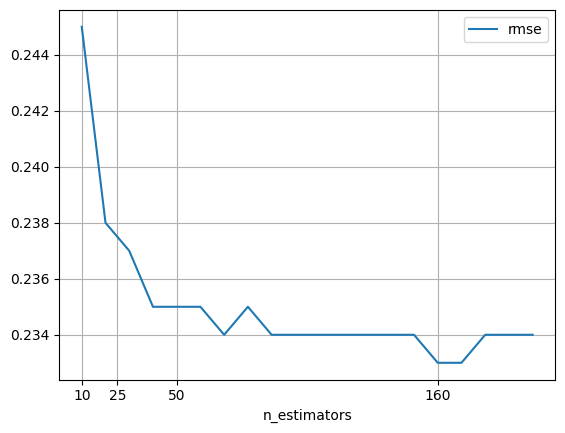

In [13]:
dft = pd.DataFrame(rmses, index=[v[0] for v in rmses], columns=['n_estimators', 'rmse'])
dft.plot(x='n_estimators', y='rmse');
plt.grid('both');
plt.xticks([10, 25, 50, 160]);

In [14]:
dft.rmse.idxmin()

160

> **Answer 3**: `160`

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [15]:
rmses = {}

for max_depth in [10, 15, 20, 25]:
    print(f'{max_depth=}')
    rmses[max_depth] = []
    for n_estimator in np.arange(10, 201, 10):
        # print(f'{n_estimator=:4d}')
        model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimator, random_state=random_seed, n_jobs=-1)
        model.fit(X_train, y_train)
        rmses[max_depth].append(
            np.sqrt(
                mean_squared_error(
                    model.predict(X_val), 
                    y_val
                )
            ).round(3)
        )
        
    rmses[max_depth] = np.mean(rmses[max_depth])

max_depth=10
max_depth=15
max_depth=20
max_depth=25


10    0.24540
15    0.23600
20    0.23535
25    0.23490
dtype: float64

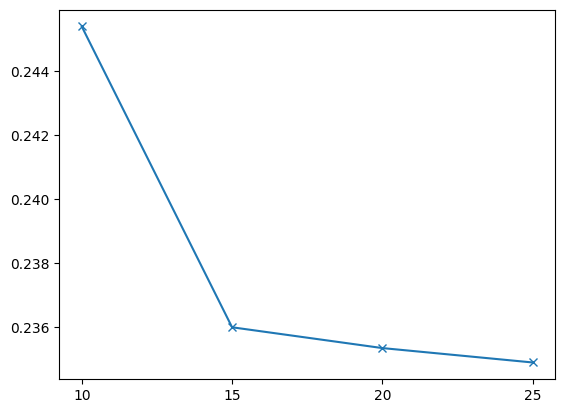

In [16]:
dft = pd.Series(rmses)
dft.plot(marker='x');
plt.xticks(dft.index);
display(dft)

> **Answer 4**: `25`

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [17]:
model = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=random_seed, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
model.feature_importances_

array([0.01495348, 0.03019435, 0.10189142, 0.0861758 , 0.33566849,
       0.29247297, 0.07380644, 0.02682069, 0.01624481, 0.02177155])

In [19]:
dv.feature_names_

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [20]:
s = pd.Series(model.feature_importances_, index=dv.feature_names_)
s.loc[['total_rooms', 'median_income', 'total_bedrooms', 'longitude']].sort_values(ascending=False)

median_income     0.335668
longitude         0.086176
total_rooms       0.021772
total_bedrooms    0.016245
dtype: float64

> **Answer 5**: `median_income`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [21]:
list(dv.get_feature_names_out())

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [22]:
features = [f.replace('<', '_') for f in list(dv.get_feature_names_out())]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/home/ubuntu/.pyenv/versions/3.11.3/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [23]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [24]:
rmses = {}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, evals_result=rmses)

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.31556	val-rmse:0.32382
[3]	train-rmse:0.28541	val-rmse:0.29965
[4]	train-rmse:0.26573	val-rmse:0.28417
[5]	train-rmse:0.25338	val-rmse:0.27463
[6]	train-rmse:0.24157	val-rmse:0.26770
[7]	train-rmse:0.23486	val-rmse:0.26423
[8]	train-rmse:0.22668	val-rmse:0.25820
[9]	train-rmse:0.21995	val-rmse:0.25444
[10]	train-rmse:0.21444	val-rmse:0.25179
[11]	train-rmse:0.21155	val-rmse:0.25054
[12]	train-rmse:0.20729	val-rmse:0.24791
[13]	train-rmse:0.20317	val-rmse:0.24628
[14]	train-rmse:0.20135	val-rmse:0.24630
[15]	train-rmse:0.19858	val-rmse:0.24522
[16]	train-rmse:0.19580	val-rmse:0.24445
[17]	train-rmse:0.19333	val-rmse:0.24395
[18]	train-rmse:0.19107	val-rmse:0.24284
[19]	train-rmse:0.18735	val-rmse:0.24127
[20]	train-rmse:0.18524	val-rmse:0.23978
[21]	train-rmse:0.18332	val-rmse:0.23963
[22]	train-rmse:0.18189	val-rmse:0.23892
[23]	train-rmse:0.18006	val-rmse:0.23847
[24]	train-rmse:0.17869	va

In [25]:
xgb_params['eta'], rmses['train']['rmse'][-1], rmses['val']['rmse'][-1] 

(0.3, 0.10988594570678918, 0.22862318255329048)

In [26]:
xgb_params['eta'] = 0.1

In [27]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, evals_result=rmses)

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269
[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	va

In [28]:
xgb_params['eta'], rmses['train']['rmse'][-1], rmses['val']['rmse'][-1] 

(0.1, 0.16323215675879393, 0.2320892516588856)

> **Answer 6**: `eta=0.3`